In [8]:
import numpy as np
import matplotlib.pyplot as plt

F = 96485  # Faraday constant [C/mol]

class BatteryMuPlot:
    def __init__(self, ocv_anode, ocv_cathode, np_ratio=1.0, soc=0.5, resolution=300):
        self.ocv_anode = ocv_anode
        self.ocv_cathode = ocv_cathode
        self.np_ratio = np_ratio
        self.soc = soc
        self.sol = np.linspace(0, 1, resolution)
        self._compute()

    def _compute(self):
        self.sol_an = self.soc
        self.sol_cath = 1 - self.soc

        self.ocv_an = self.ocv_anode(self.sol)
        self.ocv_cath = self.ocv_cathode(self.sol)

        self.mu_an = -F * self.ocv_an
        self.mu_cath = -F * self.ocv_cath

        self.mu_an_soc = -F * self.ocv_anode(self.sol_an)
        self.mu_cath_soc = -F * self.ocv_cathode(self.sol_cath)
        self.delta_U = (self.mu_cath_soc - self.mu_an_soc) / F

    def set_soc(self, soc):
        self.soc = soc
        self._compute()

    def set_np_ratio(self, np_ratio):
        self.np_ratio = np_ratio
        # placeholder — could recompute SoL mapping based on capacity
        self._compute()

    def plot_lines(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.sol, self.mu_cath, color='red', label='Cathode μₗᵢ')
        plt.plot(self.sol, self.mu_an, color='blue', label='Anode μₗᵢ')

        # Y-axis in volts
        volt_ticks = np.linspace(0, 5, 11)
        mu_ticks = -F * volt_ticks
        plt.yticks(mu_ticks, [f"{v:.1f}" for v in volt_ticks])
        plt.ylim(mu_ticks[-1], mu_ticks[0])
        plt.ylabel("Voltage vs Li⁺/Li [V]")
        plt.xlabel("State of Lithiation (SoL)")
        plt.xlim(0,self.np_ratio)
        plt.grid(True)
        plt.legend()

    def annotate_soc(self):
        # Fill areas
        plt.fill_between(self.sol[self.sol <= self.sol_cath],
                         self.mu_cath[self.sol <= self.sol_cath],
                         self.mu_cath_soc,
                         color='red', alpha=0.3, label='Lithium in Cathode')

        plt.fill_between(self.sol[self.sol <= self.sol_an],
                         self.mu_an[self.sol <= self.sol_an],
                         self.mu_an_soc,
                         color='blue', alpha=0.3, label='Lithium in Anode')

        # Vertical dashed lines
        plt.axvline(self.sol_cath, color='red', linestyle='--', alpha=0.6)
        plt.axvline(self.sol_an, color='blue', linestyle='--', alpha=0.6)

        # Voltage arrow
        arrow_x = (self.sol_cath + self.sol_an) / 2
        plt.annotate('', xy=(arrow_x, self.mu_an_soc), xytext=(arrow_x, self.mu_cath_soc),
                     arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
        label_y = (self.mu_an_soc + self.mu_cath_soc) / 2
        plt.text(arrow_x + 0.02, label_y, f'{self.delta_U:.2f} V',
                 va='center', ha='left', fontsize=12, fontweight='bold')

        # Finalize
        plt.title(f"Lithium Chemical Potential vs. SoL (SoC = {self.soc:.2f})")
        plt.tight_layout()
        plt.show()

    def query_voltage(self, sol_query):
        U_cath = self.ocv_cathode(sol_query)
        U_an = self.ocv_anode(sol_query)
        voltage = U_cath - U_an
        print(f"At SoL = {sol_query:.2f}:")
        print(f"  Cathode OCV  = {U_cath:.3f} V")
        print(f"  Anode OCV    = {U_an:.3f} V")
        print(f"  Cell voltage = {voltage:.3f} V")
        
    def annotate_soc(self):
        fig, (ax_mu, ax_ocv) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, height_ratios=[3, 1])

        # === μ_Li Plot ===
        ax_mu.plot(self.sol, self.mu_cath, color='red', label='Cathode μₗᵢ')
        ax_mu.plot(self.sol, self.mu_an, color='blue', label='Anode μₗᵢ')

        ax_mu.fill_between(self.sol[self.sol <= self.sol_cath],
                        self.mu_cath[self.sol <= self.sol_cath],
                        self.mu_cath_soc,
                        color='red', alpha=0.3)
        ax_mu.fill_between(self.sol[self.sol <= self.sol_an],
                        self.mu_an[self.sol <= self.sol_an],
                        self.mu_an_soc,
                        color='blue', alpha=0.3)

        # Dots at μ_li (SoC)
        ax_mu.plot(self.sol_cath, self.mu_cath_soc, 'o', color='red', markersize=10)
        ax_mu.plot(self.sol_an, self.mu_an_soc, 'o', color='blue', markersize=10)

        # Arrow indicating delta μ, aligned with full-cell SoL_cath
        arrow_x = self.sol_cath
        ax_mu.annotate('', xy=(arrow_x, self.mu_an_soc), xytext=(arrow_x, self.mu_cath_soc),
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
        label_y = (self.mu_an_soc + self.mu_cath_soc) / 2
        ax_mu.text(arrow_x + 0.02, label_y, f'{self.delta_U:.2f} V',
                va='center', ha='left', fontsize=12, fontweight='bold')

        # Y-axis in volts
        volt_ticks = np.linspace(0, 5, 11)
        mu_ticks = -F * volt_ticks
        ax_mu.set_yticks(mu_ticks)
        ax_mu.set_yticklabels([f"{v:.1f}" for v in volt_ticks])
        ax_mu.set_ylim(mu_ticks[-1], mu_ticks[0])
        ax_mu.set_ylabel("Voltage vs Li⁺/Li [V]")
        ax_mu.legend()
        ax_mu.grid(True)
        ax_mu.set_title(f"Lithium Chemical Potential vs. SoL (SoC = {self.soc:.2f})")
        ax_mu.set_xlim(0,self.np_ratio)

        # === Full-cell OCV Plot ===
        soc_vec = self.sol  # same resolution
        sol_cath_vec = soc_vec
        sol_an_vec = 1 - sol_cath_vec
        U_cath_vec = self.ocv_cathode(sol_cath_vec)
        U_an_vec = self.ocv_anode(sol_an_vec)
        U_cell_vec = U_cath_vec - U_an_vec

        ax_ocv.plot(sol_cath_vec, U_cell_vec, color='black', label='Full-Cell OCV')
        ax_ocv.axvline(self.sol_cath, color='gray', linestyle='--', alpha=0.6)

        # Dot at SoC point
        ax_ocv.plot(self.sol_cath, self.delta_U, 'ko', markersize=8)
        ax_ocv.set_ylabel("Cell Voltage [V]")
        ax_ocv.set_xlabel("State of Lithiation of Cathode (SoL₍cath₎)")
        ax_ocv.grid(True)
        ax_ocv.legend()

        plt.tight_layout()
        plt.show()


C:\Users\Lvk\AppData\Local\Temp\ipykernel_29096\1538543533.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


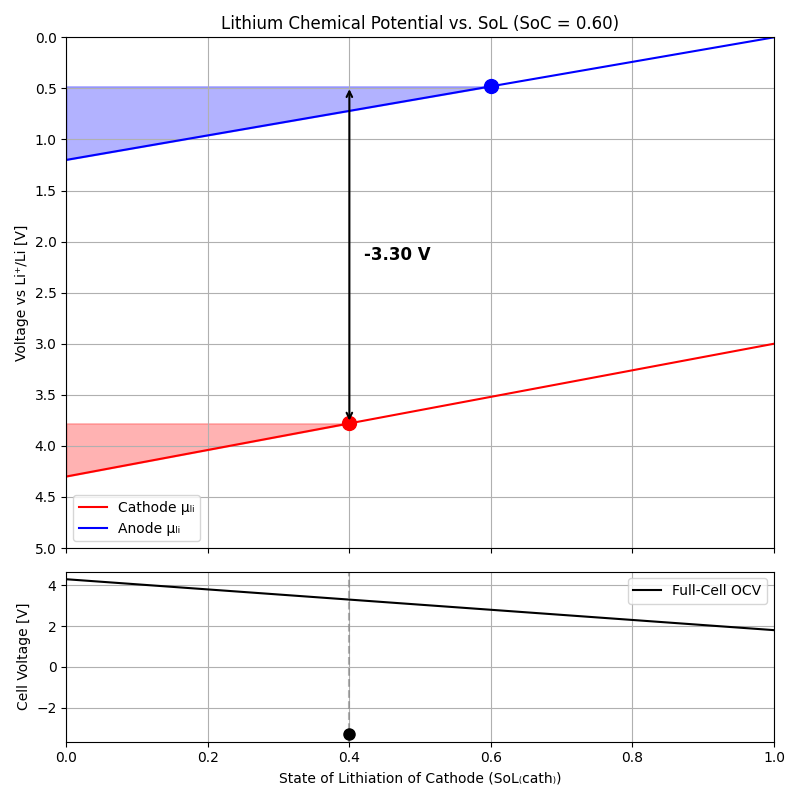

At SoL = 0.30:
  Cathode OCV  = 3.910 V
  Anode OCV    = 0.840 V
  Cell voltage = 3.070 V


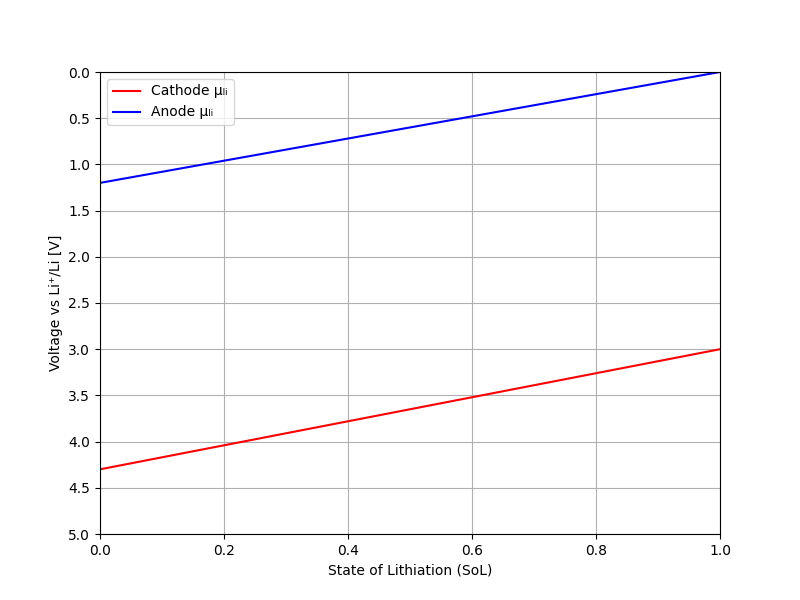

In [9]:
# Example OCV functions (real ones decrease with SoL)
def ocv_anode(sol):    # e.g., graphite
    return 1.2-1.2*sol

def ocv_cathode(sol):  # e.g., NMC
    return 4.3-sol*1.3
# Create plot object
plotter = BatteryMuPlot(ocv_anode=ocv_anode, ocv_cathode=ocv_cathode, soc=0.6)

# Plot base curves
plotter.plot_lines()

# Annotate SoC
plotter.annotate_soc()

# Query voltage at arbitrary SoL
plotter.query_voltage(sol_query=0.3)


In [10]:
from ipywidgets import interact, FloatSlider
%matplotlib widget

# Define the interactive control
def interactive_mu_plot(soc=0.5):
    plotter = BatteryMuPlot(ocv_anode=ocv_anode, ocv_cathode=ocv_cathode, soc=soc)
    plotter.annotate_soc()

# Display the widget
interact(
    interactive_mu_plot,
    soc=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description="SoC")
);


interactive(children=(FloatSlider(value=0.5, description='SoC', max=0.99, min=0.01, step=0.01), Output()), _do…

In [ ]:
from ipywidgets import interact, FloatSlider

def interactive_mu_plot(soc=0.5, np_ratio=1.0):
    plotter = BatteryMuPlot(
        ocv_anode=ocv_anode,
        ocv_cathode=ocv_cathode,
        soc=soc,
        np_ratio=np_ratio
    )
    plotter.plot_lines()
    plotter.annotate_soc()
